In [209]:
# Para instalar las librerías, solo tiene que ser una vez
if False :
    !pip install PyMuPDF
    !pip install Pillow
    !pip install opencv-python
    !pip install imutils

In [ ]:
import os
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import fitz # From PyMuPDF
from PIL import Image
import cv2
import argparse
import imutils
import sys

In [2]:
os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
# os.chdir(r'C:\Users\gd.orbegozo10\Dropbox\Cosas_Programacion\Python\python\formatos_elecciones')

In [3]:
png_dir = 'formularios_e_14/pdf_crop/'
png_list = os.listdir(png_dir)
png_list[1:11]

['2000015_E14_PRE_X_16_001_016_XX_13_030_X_XXX.png',
 '2000115_E14_PRE_X_15_103_000_XX_00_002_X_XXX.png',
 '2000210_E14_PRE_X_29_001_007_XX_02_006_X_XXX.png',
 '2000219_E14_PRE_X_16_001_009_XX_12_004_X_XXX.png',
 '2000414_E14_PRE_X_31_001_030_XX_01_016_X_XXX.png',
 '2000417_E14_PRE_X_25_001_007_XX_06_007_X_XXX.png',
 '2000418_E14_PRE_X_27_071_000_XX_00_013_X_XXX.png',
 '2000513_E14_PRE_X_01_218_002_XX_02_001_X_XXX.png',
 '2000514_E14_PRE_X_29_085_000_XX_00_015_X_XXX.png',
 '2000515_E14_PRE_X_09_130_001_XX_02_012_X_XXX.png']

In [9]:
png_dir + png_list[1]

'formularios_e_14/pdf_crop/2000015_E14_PRE_X_16_001_016_XX_13_030_X_XXX.png'

In [14]:
img = cv2.imread(png_dir + png_list[1])
img.shape
        

(1143, 775, 3)

# Hacemos un loop que itere sobre las imagenes de la carpeta para obtener el número de píxeles horizontal y vertical de todas


In [152]:
# Defino la función de la barra de progreso
def progressBar(value, endvalue, msg='', bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(f"\rProgreso: [{arrow + spaces}] {int(round(percent * 100))}% ({value+1} de {endvalue} imagenes)")
    sys.stdout.flush()

In [212]:
ancho = []
largo = []

for i, x in enumerate(png_list):
    img = cv2.imread(png_dir + x)
    largo.append(img.shape[0])
    ancho.append(img.shape[1])
    progressBar(i,len(png_list))

Progreso: [--------------------------------------->] 100% (94949 de 94950 imagenes)

# Revisar la distribución

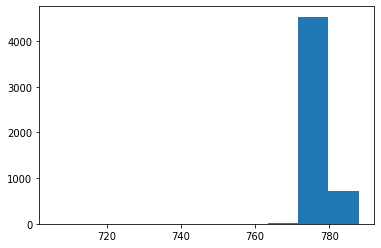

,0
count,5272.000000
mean,777.204097
std,2.551997
min,706.000000
25%,776.000000
50%,777.000000
75%,778.000000
max,788.000000


In [25]:
plt.hist(ancho)
plt.show()
df_ancho = pd.DataFrame(ancho)
df_ancho.describe()

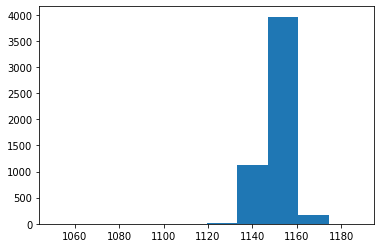

,0
count,5272.000000
mean,1149.452011
std,5.564268
min,1051.000000
25%,1147.000000
50%,1150.000000
75%,1152.000000
max,1188.000000


In [26]:
plt.hist(largo)
plt.show()
df_largo = pd.DataFrame(largo)
df_largo.describe()

In [57]:
df = pd.DataFrame({"ancho":ancho,"largo":largo})
df

,ancho,largo
0,776,1157
1,775,1143
2,775,1144
3,776,1159
4,777,1149
...,...,...
5267,776,1148
5268,774,1150
5269,772,1145
5270,775,1149


In [77]:
df["perc_25_75_ancho"] = (df.ancho >= np.percentile(ancho,25)) & (df.ancho <= np.percentile(ancho,75))
df["perc_25_75_largo"] = (df.largo >= np.percentile(largo,25)) & (df.largo <= np.percentile(largo,75))
df["perc_25_75_ambos"] = (df.perc_25_75_ancho == True) & (df.perc_25_75_largo == True)

In [78]:
df.perc_25_75_ancho.value_counts()

True     2960
False    2312
Name: perc_25_75_ancho, dtype: int64

In [79]:
df.perc_25_75_largo.value_counts()

True     2978
False    2294
Name: perc_25_75_largo, dtype: int64

In [80]:
df.perc_25_75_ambos.value_counts()

False    3489
True     1783
Name: perc_25_75_ambos, dtype: int64

In [81]:
df

,ancho,largo,perc_25_75_ancho,perc_25_75_largo,perc_25_75_ambos
0,776,1157,True,False,False
1,775,1143,False,False,False
2,775,1144,False,False,False
3,776,1159,True,False,False
4,777,1149,True,True,True
...,...,...,...,...,...
5267,776,1148,True,True,True
5268,774,1150,False,True,False
5269,772,1145,False,False,False
5270,775,1149,False,True,False


# Separar números de las imágenes

In [5]:
png_name = png_list[5267]
img = cv2.imread(png_dir + png_name)
img_rect = cv2.imread(png_dir + png_name)

In [6]:
png_name

'2394111_E14_PRE_X_21_001_006_XX_06_011_X_XXX.png'

In [6]:
# Defino la función que cropea los números de cada imagen
def crop_digits(png_name, save_dir, png_dir='formularios_e_14/pdf_crop/', debug=False) :
    
    # Cargo la imagen 
    img = cv2.imread(png_dir + png_name)
    img_rect = cv2.imread(png_dir + png_name)
    
    contador = 0

    # Loop para cropear los números totales (sección 1)
    row = 160
    col = 0
    for horizontal_move in range(3):
        for horizontal_move_2 in range(3):
            row_temp = row
            x0, y0 = col, row_temp

            row_temp += 49
            col += 70
            extra_row = 15
            extra_col = 10
            x1, y1 = col + extra_col, row_temp + extra_row

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,0,250), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
            cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            contador += 1

        col += 70

    # Loop para cropear los números de los votos (sección 2) 

    row = 285
    col = 555
    for vertical_move in range(8):
        col_temp = col

        for horizontal_move in range(3):

            row_temp = row
            x0, y0 = col_temp, row_temp

            row_temp += 66
            col_temp += 71

            extra_row = 15
            extra_col = 10

            x1, y1 = col_temp + extra_col, row_temp + extra_col

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,250,0), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
            cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            contador += 1

        row =  row_temp + 5 

    # Loop para cropear los números de los votos en blanco nulos etc (sección 3)

    row = 850
    col = 555
    for vertical_move in range(4):
        col_temp = col

        for horizontal_move in range(3):

            row_temp = row
            x0, y0 = col_temp, row_temp

            row_temp += 58
            col_temp += 71

            extra_row = 18
            extra_col = 10

            x1, y1 = col_temp + extra_col, row_temp + extra_col

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (250,0,0), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
            cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            contador += 1

        row =  row_temp + 5 

    if debug :    
        # Saco la imagen con los cuadros    
        cv2.imwrite(f'{save_dir}/{png_name}',img_rect)
        

In [10]:
png_name = png_list[2560]

crop_digits(png_name, 'test/save_images')

## INTENTAR VARIOS MÉTODOS PARA GUARDAR UNA GRAN CANTIDAD DE IMÁGENES

* El primer método, que ya está en la función de arriba guarda cada dígito en un png en una carpeta, esos son 45 imágenes por cada uno de lo 95k formatos.

In [4]:
import lmdb
import h5py

In [121]:
def save_img_h5(img, key, save_dir, h5_name) :
        # Abrir el archivo h5 para guardar las imágenes
    with h5py.File(f'{save_dir}/{h5_name}.h5', 'a') as h5_f :
        # Create the image and palette dataspaces
        dset = h5_f.create_dataset(name=key, data=img)

        # Set the image attributes
        dset.attrs['CLASS'] = 'IMAGE'
        dset.attrs['IMAGE_VERSION'] = '1.2'
        dset.attrs['IMAGE_SUBCLASS'] =  'IMAGE_INDEXED'
        dset.attrs['IMAGE_MINMAXRANGE'] = np.array([0,255], dtype=np.uint8)    
    
# Defino la función que cropea los números de cada imagen
def crop_digits_h5(png_name, save_dir, h5_name, png_dir='formularios_e_14/pdf_crop/', debug=False) :
    
    # Cargo la imagen 
    img = cv2.imread(png_dir + png_name)
    img_rect = cv2.imread(png_dir + png_name)

    contador = 0
    
    png_name = png_name[:-4]

    # Loop para cropear los números totales (sección 1)
    row = 160
    col = 0
    for horizontal_move in range(3):
        for horizontal_move_2 in range(3):
            row_temp = row
            x0, y0 = col, row_temp

            row_temp += 49
            col += 70
            extra_row = 15
            extra_col = 10
            x1, y1 = col + extra_col, row_temp + extra_row

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,0,250), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            save_img_h5(
                img=digito, 
                key=f'{contador}_{png_name}', 
                save_dir=save_dir,
                h5_name=h5_name
            )
            contador += 1

        col += 70

    # Loop para cropear los números de los votos (sección 2) 

    row = 285
    col = 555
    for vertical_move in range(8):
        col_temp = col

        for horizontal_move in range(3):

            row_temp = row
            x0, y0 = col_temp, row_temp

            row_temp += 66
            col_temp += 71

            extra_row = 15
            extra_col = 10

            x1, y1 = col_temp + extra_col, row_temp + extra_col

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,250,0), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            save_img_h5(
                img=digito, 
                key=f'{contador}_{png_name}', 
                save_dir=save_dir,
                h5_name=h5_name
            )
            contador += 1

        row =  row_temp + 5 

    # Loop para cropear los números de los votos en blanco nulos etc (sección 3)

    row = 850
    col = 555
    for vertical_move in range(4):
        col_temp = col

        for horizontal_move in range(3):

            row_temp = row
            x0, y0 = col_temp, row_temp

            row_temp += 58
            col_temp += 71

            extra_row = 18
            extra_col = 10

            x1, y1 = col_temp + extra_col, row_temp + extra_col

            # Dibujo el rectangulo sobre la imagen
            img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (250,0,0), 1)

            # Recorto el dígito
            digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
            save_img_h5(
                img=digito, 
                key=f'{contador}_{png_name}', 
                save_dir=save_dir,
                h5_name=h5_name
            )
            contador += 1

        row =  row_temp + 5 

    if debug :    
        # Saco la imagen con los cuadros    
        cv2.imwrite(f'{save_dir}/{png_name}',img_rect)
        
    h5_f.close()

In [156]:
import random
import shutil

random.seed(666)

png_index = random.sample(range(len(png_list)),100)

if os.path.exists("demofile.txt"): os.remove("test/test_h5_1.h5")
for i,x in enumerate(png_index) :
    crop_digits_h5(
        png_name=png_list[x],
        save_dir='test/',
        h5_name='test_h5_1',
    )
    progressBar(i, len(png_index))
    
print("\n") 

digit_png_file = 'test/save_images'
shutil.rmtree(digit_png_file, ignore_errors=True)
os.mkdir(digit_png_file)
for i,x in enumerate(png_index) :
    crop_digits(
        png_name=png_list[x],
        save_dir=digit_png_file
    )
    progressBar(i, len(png_index))

Progreso: [--------------------------------------->] 99% (100 de 100 imagenes)

Progreso: [--------------------------------------->] 99% (100 de 100 imagenes)

In [119]:
a

'102001416_E14_PRE_X_01_001_003_XX_01_034_X_XXX'

4500


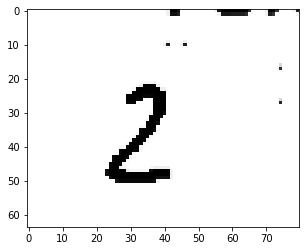

In [164]:
with h5py.File(f'test/test_h5_1.h5', 'r') as f_read:
    print(len(f_read.keys()))
    plt.imshow(list(f_read[list(f_read.keys())[20]]))
    plt.show()
    f_read.close()

In [198]:
png_name = png_list[2000]


# Cargo la imagen 
img = cv2.imread(png_dir + png_name)
img_rect = cv2.imread(png_dir + png_name)

contador = 0

png_name = png_name[:-4]

digit_array = []
key_array = []
# Loop para cropear los números totales (sección 1)
row = 160
col = 0
for horizontal_move in range(3):
    for horizontal_move_2 in range(3):
        row_temp = row
        x0, y0 = col, row_temp

        row_temp += 49
        col += 70
        extra_row = 15
        extra_col = 10
        x1, y1 = col + extra_col, row_temp + extra_row

        # Dibujo el rectangulo sobre la imagen
        img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,0,250), 1)

        # Recorto el dígito
        digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
        digit_array.append(digito)
        key_array.append(f'{contador}_{png_name}')
        contador += 1

    col += 70

# Loop para cropear los números de los votos (sección 2) 

row = 285
col = 555
for vertical_move in range(8):
    col_temp = col

    for horizontal_move in range(3):

        row_temp = row
        x0, y0 = col_temp, row_temp

        row_temp += 66
        col_temp += 71

        extra_row = 15
        extra_col = 10

        x1, y1 = col_temp + extra_col, row_temp + extra_col

        # Dibujo el rectangulo sobre la imagen
        img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (0,250,0), 1)

        # Recorto el dígito
        digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
        digit_array.append(digito)
        key_array.append(f'{contador}_{png_name}')
        contador += 1

    row =  row_temp + 5 

# Loop para cropear los números de los votos en blanco nulos etc (sección 3)

row = 850
col = 555
for vertical_move in range(4):
    col_temp = col

    for horizontal_move in range(3):

        row_temp = row
        x0, y0 = col_temp, row_temp

        row_temp += 58
        col_temp += 71

        extra_row = 18
        extra_col = 10

        x1, y1 = col_temp + extra_col, row_temp + extra_col

        # Dibujo el rectangulo sobre la imagen
        img_rect = cv2.rectangle(img_rect, (x0, y0), (x1, y1), (250,0,0), 1)

        # Recorto el dígito
        digito = img[y0:y1,x0:x1]
#                 cv2.imwrite(f'{save_dir}/{contador}_{png_name}',digito)
        digit_array.append(digito)
        key_array.append(f'{contador}_{png_name}')
        contador += 1

    row =  row_temp + 5 
digit_array = np.asarray(digit_array)
key_array = np.asarray(key_array)

In [203]:
with h5py.File(f'test/test_2.h5', 'a') as file :
    dataset = file.create_dataset(
        "images", np.shape(digit_array), h5py.h5t.STD_U8BE, data=digit_array
    )
    meta_set = file.create_dataset(
        "meta", np.shape(key_array), h5py.STD_U8BE, data=key_array
    )


OSError: Can't write data (no appropriate function for conversion path)

In [196]:
np.asarray(digit_array).shape

(45,)

In [192]:
array

array([[ 0,  2,  4,  6,  8],
       [10, 12, 14, 16, 18],
       [20, 22, 24, 26, 28],
       [30, 32, 34, 36, 38],
       [40, 42, 44, 46, 48]])

In [186]:
archive = h5py.File('test/test.h5', 'w')

archive.create_dataset('/array', data=array)

archive.close()

1


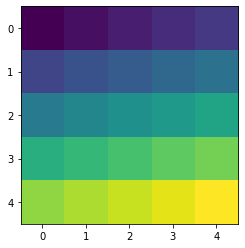

In [188]:
with h5py.File(f'test/test.h5', 'r') as f_read:
    print(len(f_read.keys()))
    plt.imshow(list(f_read[list(f_read.keys())[0]]))
    plt.show()
    f_read.close()